# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики точность (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
iris = datasets.load_iris()

In [ ]:
df= pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                 columns= iris['feature_names'] + ['target'])
df.sample()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
22,4.6,3.6,1.0,0.2,0.0


### Реализуем функции

Ввиду того, что в задании сказано "на вход функции подаётся датафрейм с объектами", будем реализовавыть функции так, что бы им на вход поступал DataFrame

In [ ]:
def make_split(j, t, df):
    left = df[df[df.columns[j]] < t]
    right = df[df[df.columns[j]] >= t]

    return left, right


def calc_IG(df, sample1, sample2):
    size_R_v = len(df[df.columns[-1]])
    size_R_left = len(sample1[sample1.columns[-1]])
    size_R_right = len(sample2[sample2.columns[-1]])

    IG = entropy(df[df.columns[-1]]) - (
            size_R_left / size_R_v * entropy(sample1[sample1.columns[-1]]) +
            size_R_right / size_R_v * entropy(sample2[sample2.columns[-1]])
    )

    return IG


def get_best_split(df):
    best_j, best_t, best_IG = 0, 0.0, 0.0

    for j in range(len(df.columns) - 1):
        for t in df[df.columns[j]]:
            left, right = make_split(j, t, df)
            cur_IG = calc_IG(df, left, right)

            if cur_IG > best_IG:
                best_j, best_t, best_IG = j, t, cur_IG

    return {'index': best_j, 'value': best_t, 'children': make_split(best_j, best_t, df)}


def to_terminal(sample):
    return sample[sample.columns[-1]].value_counts().index[0]


def split_node(node, max_depth, min_size, purity, depth):
    left, right = node['children']
    del (node['children'])

    if purity:
        if left.value_counts().size == 1:
            to_terminal(left)
            return
        if right.value_counts().size == 1:
            to_terminal(right)
            return

    if left.empty or right.empty:
        node['left'] = node['right'] = to_terminal(pd.concat([left, right]))
        return

    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_best_split(left)
        split_node(node['left'], max_depth, min_size, purity, depth + 1)

    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_best_split(right)
        split_node(node['right'], max_depth, min_size, purity, depth + 1)


def build_tree(train, max_depth, min_size, purity):
    root = get_best_split(train)
    split_node(root, max_depth, min_size, purity, 1)
    return root


def predict_row(node, row_df):
    if row_df[row_df.columns[node['index']]].iloc[0] < node['value']:
        if isinstance(node['left'], dict):
            return predict_row(node['left'], row_df)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict_row(node['right'], row_df)
        else:
            return node['right']


def predict_df(node, df_test):
    y_pred = []
    for i in range(df_test.shape[0]):
        row_df = df_test.iloc[[i]]
        pred_class = predict_row(node, row_df)

        y_pred.append(pred_class)

    return y_pred




---



### Протестируем

In [ ]:
train_size = 120
df_train = df.sample(train_size, random_state=42)
df_test = df.drop(df_train.index)

max_depth = 3
min_size = 1
tree = build_tree(df_train, max_depth, min_size, False)

In [ ]:
accuracies = []
for i_depth in range(1, 10):
  tree = build_tree(df_train, i_depth, 1, False)

  accuracies.append(accuracy_score(df_test[df_test.columns[-1]], predict_df(tree, df_test)))

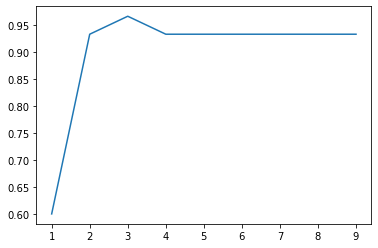

In [ ]:
plt.plot(range(1, 10), accuracies)

Таким образом, ниилучшая глубина равна **3**. Дальнейшее усложнение дерева ведет к переобучению.



---



##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации, бэггинг) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
churn = pd.read_csv('/content/drive/MyDrive/!ITMO/ML/Data/churn.csv')
churn.sample(5, random_state=2021)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1955,1956,15779176,Dike,565,Germany,Female,58,3,108888.24,3,0,1,135875.51,1
8233,8234,15589019,Morant,633,Spain,Female,33,4,92855.02,1,1,1,159813.18,0
156,157,15655007,Li,758,France,Female,33,7,0.00,2,0,0,82996.47,0
8623,8624,15666197,Boni,430,Germany,Female,38,8,153058.64,1,1,0,99377.27,0
6962,6963,15683892,Fraser,677,Germany,Female,26,3,102395.79,1,1,0,119368.99,0


### Проанализируем данные

In [ ]:
# numeric features
num_cols = [
    #'RowNumber', from the data description - this column is useless
    #'CustomerId', from the data description - this column is useless
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember',
    'EstimatedSalary'
]

# categorical features
cat_cols = [
    # 'Surname', from the data description - this column is useless
    'Geography',
    'Gender'
]

feature_cols = num_cols + cat_cols
target_col = 'Exited'

In [ ]:
churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
churn.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

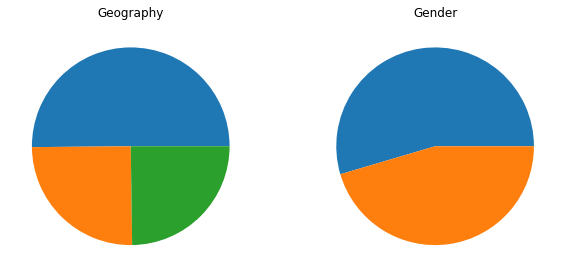

In [ ]:
n = math.ceil(math.sqrt(len(cat_cols)))

plt.figure(figsize=(10, 10))
for i in range(0, len(cat_cols)):
    plt.subplot(n, n, i+1)
    plt.pie(churn[cat_cols[i]].value_counts())
    plt.title(cat_cols[i])

plt.show()

### Обработаем данные

Из описания данных (https://www.kaggle.com/mathchi/churn-for-bank-customers) можем заключить, что RowNumber, CustomerId и Surname ни как не влиют на отток клиента. Исключим эти признаки.

In [ ]:
df = churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [ ]:
# one-hot encoding
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)
# normalize numerical features 
df[num_cols] = StandardScaler().fit(df[num_cols]).transform(df[num_cols])

X = df.loc[:, df.columns != target_col]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2021)



---



### Реализуем RandomForest

In [ ]:
# bootstrap
class MyRandomForest():
  def __init__(self, N=100, criterion='entropy', max_depth=11, min_samples_leaf=2, max_features='sqrt'):
    self.trees = []

    self.N = N
    self.criterion = criterion
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.max_features = max_features

  def fit(self, X_train, y_train):
    m = X_train.shape[0]

    for n in range(self.N):
      X_n = X_train.sample(n=m, replace=True) # bootstrap
      b_n = DecisionTreeClassifier(criterion=self.criterion, 
                                  max_depth=self.max_depth, 
                                  min_samples_leaf=self.min_samples_leaf, 
                                  max_features=self.max_features)
      b_n.fit(X_train, y_train)
      self.trees.append(b_n)

    #return self.trees.copy()

  def _predict_row(self, X_row):
    predictions = []

    for i in range(len(self.trees)):
      predictions.append(self.trees[i].predict(X_row))
    
    predictions_int = []
    for a in predictions:
      predictions_int.append(a[0])

    return max(set(predictions_int), key=predictions_int.count)

  def predict(self, X_test):
    y_pred = []

    for i in range(X_test.shape[0]):
      y_pred.append(self._predict_row(X_test.iloc[[i]]) )
      

    return y_pred

  def score(self, X_test, y_true):
    y_pred = self.predict(X_test)

    return accuracy_score(y_true, y_pred)



---



### Протестируем алгоритм

In [ ]:
model = MyRandomForest(N=200)
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.8563636363636363

In [ ]:
model = MyRandomForest(N=11)
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.8518181818181818

#### Настроим гиперпараметры

N

In [ ]:
b_N, b_score = 1, 0.0
for i_N in range(50, 201, 50):
  model = MyRandomForest(N=i_N)
  model.fit(X_train, y_train)

  scr = model.score(X_test, y_test)

  if scr > b_score:
    b_N, b_score = i_N, scr

In [ ]:
print(f'Best number of trees N={b_N}')

Best number of trees N=150


max_depth

In [ ]:
b_max_depth, b_score = 1, 0.0
for i_max_depth in range(2, 12, 3):
  model = MyRandomForest(max_depth=i_max_depth)
  model.fit(X_train, y_train)

  scr = model.score(X_test, y_test)

  if scr > b_score:
    b_max_depth, b_score = i_max_depth, scr

In [ ]:
print(f'Best max_depth={b_N}')

Best max_depth=11


criterion

In [ ]:
#gini
model = MyRandomForest(criterion='gini')
model.fit(X_train, y_train)
scr_gini = model.score(X_test, y_test)

#entropy
model = MyRandomForest(criterion='entropy')
model.fit(X_train, y_train)
scr_entropy = model.score(X_test, y_test)

if scr_gini >= scr_entropy:
  print('Best criterion is gini')
else:
  print('Best criterion is entropy')

Best criterion is entropy


### Интерпретация

Будем удалять признаки по одному и смотреть влияние на accuracy

In [ ]:
model = MyRandomForest()
model.fit(X_train, y_train)

score_all_features = model.score(X_test, y_test)

In [ ]:
b_feature, b_min_score_diff = '', score_all_features + 1
for i_cl in range(len(X_train.columns)):
  X_train_dropped = X_train.drop(columns=[X_train.columns[i_cl]])
  X_test_dropped = X_test.drop(columns=[X_test.columns[i_cl]])

  model = MyRandomForest()
  model.fit(X_train_dropped, y_train)

  scr = model.score(X_test_dropped, y_test)

  # check how they close to each other
  if (score_all_features - scr) < b_min_score_diff:
    b_feature = i_cl
    b_min_score_diff = score_all_features - scr


In [ ]:
print(f'The most inportant feature is {X_train.columns[b_feature]}')

The most inportant feature is HasCrCard
